# Twitter Sentiment and Modeling

## Overview

This project utilizes a dataset from CrowdFlower, analyzing and rating the sentiment of Twitter users regarding Apple and Google products by building an NLP model. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

## Business Problem

Apple and Google want to gather information on the consensus of their products. They are looking at Twitter as a medium to gather that information. The task is to build a model that can rate the sentiment of a Tweet based on its content.

## Data Understanding

The dataset used for this project is a csv file ("data.csv"), containing over 9,000 Tweets about Apple and Google products. Human raters rated the sentiment as positive, negative, or neither. The target column is the sentiment column.

### Import Libraries

First thing we did was import the necessary libraries for analysis, visualization, preprocessing data, and building models, as well as ignore warnings.

In [1]:
#import necessary libraries
import pandas as pd

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

### Data Inspection

We proceeded to load the csv dataset, then look at the shape, size, column names and data types, as well as check for missing or duplicate entries.

In [2]:
#load the dataset, ensure the proper encoding is read
df = pd.read_csv('data.csv', encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
#change the name of the tweet, product, and sentiment columns
df = df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'brand_or_product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})
df.head()

,tweet,brand_or_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#look at the different values for sentiment column
df['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [5]:
#look at the 'I can't tell' rows
df.loc[df['sentiment'] == "I can't tell"].head()

,tweet,brand_or_product,sentiment
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell


#### Drop the "I can't tell" rows 

We decided to drop the rows labeled "I can't tell", as they would only serve to confuse the dataset, and didn't make up a significant portion of the dataset anyway. 

In [6]:
#drop the I can't tell rows
mask = df['sentiment'] == "I can't tell"
df.drop(df[mask].index, inplace=True)
print(df['sentiment'].value_counts())

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64


#### Change Sentiment Values

We decided to combine 'I can't tell' and 'No emotion toward brand or product' into the value 'Neutral', and change
'Positive emotion' and 'Negative emotion' to just 'Positive' and 'Negative'.

In [7]:
#change sentiment values
df['sentiment'] = df['sentiment'].replace({'No emotion toward brand or product': 'Neutral',
                                           'Positive emotion': 'Positive',
                                           'Negative emotion': 'Negative'})
print(df['sentiment'].value_counts())

Neutral     5389
Positive    2978
Negative     570
Name: sentiment, dtype: int64


In [8]:
#look at the different values for brand_or_product column
df['brand_or_product'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand_or_product, dtype: int64

In [9]:
#check information on each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8936 non-null   object
 1   brand_or_product  3282 non-null   object
 2   sentiment         8937 non-null   object
dtypes: object(3)
memory usage: 279.3+ KB


### Duplicates

We checked for and found duplicate records, then proceeded to drop them.

In [10]:
#check for duplicates
df[df.duplicated()]

,tweet,brand_or_product,sentiment
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
776,Google to Launch Major New Social Network Call...,NaN,Neutral
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,Neutral
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,Neutral
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",NaN,Neutral
5881,RT @mention Google to Launch Major New Social ...,NaN,Neutral


In [11]:
#check the number of duplicates
print(len(df[df.duplicated()]))

22


In [12]:
#drop duplicates
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,tweet,brand_or_product,sentiment


### Missing Values

We checked for missing values and were missing 1 value for the tweet column and almost 6,000 values for the brand_or_product column. 

In [13]:
#look at the row with the missing value for the 'tweet' column
df.loc[df['tweet'].isnull()]

,tweet,brand_or_product,sentiment
6,NaN,NaN,Neutral


#### Drop Missing Tweet 

Since there is nothing useful provided in the entire row that's the sole missing tweet, we just dropped the row.

In [14]:
#drop missing tweet row
df.dropna(subset=['tweet'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8914 non-null   object
 1   brand_or_product  3273 non-null   object
 2   sentiment         8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


Now we took a look at the missing brand/product rows.

In [15]:
#look at 20 rows of missing brand/product values
df.loc[df['brand_or_product'].isnull()].head(20)

,tweet,brand_or_product,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,Neutral
16,Holler Gram for iPad on the iTunes App Store -...,NaN,Neutral
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,Neutral
33,Anyone at #sxsw want to sell their old iPad?,NaN,Neutral
34,Anyone at #SXSW who bought the new iPad want ...,NaN,Neutral
35,At #sxsw. Oooh. RT @mention Google to Launch ...,NaN,Neutral
37,SPIN Play - a new concept in music discovery f...,NaN,Neutral
39,VatorNews - Google And Apple Force Print Media...,NaN,Neutral
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,NaN,Neutral
42,Hey #SXSW - How long do you think it takes us ...,NaN,Neutral


We looked for any correlation or pattern between missing brands and the sentiment. 

In [16]:
#check missing brand/product rows that have a sentiment other than Neutral
df.loc[(df['brand_or_product'].isnull()) & (df['sentiment'] != 'Neutral')]

,tweet,brand_or_product,sentiment
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative
103,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative
112,Spark for #android is up for a #teamandroid aw...,NaN,Positive
...,...,...,...
9011,apparently the line to get an iPad at the #sxs...,NaN,Positive
9043,Hey is anyone doing #sxsw signing up for the g...,NaN,Negative
9049,@mention you can buy my used iPad and I'll pic...,NaN,Positive
9052,@mention You could buy a new iPad 2 tmrw at th...,NaN,Positive


In [17]:
#print the number of missing brand/product rows that have a sentiment other than Neutral, and the number that have Neutral as the sentiment
print("Number of rows with a sentiment other than Neutral: ", len(df.loc[(df['brand_or_product'].isnull()) & (df['sentiment'] != 'Neutral')]))
print("Number of rows with Neutral as the sentiment: ", len(df.loc[(df['brand_or_product'].isnull()) & (df['sentiment'] == 'Neutral')]))

Number of rows with a sentiment other than Neutral:  357
Number of rows with Neutral as the sentiment:  5284


#### Modify Null Brand/Product Rows

With so many entries missing a value for the brand/product, and having a non-neutral sentiment, we proceed to write a function to fill in the brand/product if it contained one of our brand/product values in the tweet, then applied this function to the dataset. 

In [18]:
#function to change the brand/product column based on inclusion of one of the values in the tweet
def get_brand_or_product(tweet):
    tweet = tweet.lower()
    keywords = ['apple', 'google', 'iphone', 'ipad', 'android']
    count = 0
    brand_product = None

    for keyword in keywords:
        if keyword in tweet:
            count += 1
            brand_product = keyword
    #leave the column blank if more than one of the brand/product values is in the tweet
    if count > 1:
        brand_product = None

    return brand_product

In [19]:
#apply the function to the null rows in the dataset
mask = df['brand_or_product'].isnull()
df.loc[mask, 'brand_or_product'] = df.loc[mask, 'tweet'].apply(get_brand_or_product)
print(len(df.loc[df['brand_or_product'].isnull()]))

1492


In [20]:
#check the info on each column again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8914 non-null   object
 1   brand_or_product  7422 non-null   object
 2   sentiment         8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


In [21]:
#look at 20 null rows again
df.loc[df['brand_or_product'].isnull()].head(20)

,tweet,brand_or_product,sentiment
39,VatorNews - Google And Apple Force Print Media...,None,Neutral
41,HootSuite - HootSuite Mobile for #SXSW ~ Updat...,None,Neutral
51,ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS...,None,Neutral
52,÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #s...,None,Neutral
53,.@mention @mention on the location-based 'fast...,None,Neutral
66,At #sxsw? @mention / @mention wanna buy you a ...,None,Neutral
68,Boooo! RT @mention Flipboard is developing an ...,None,Negative
71,Chilcott: @mention #SXSW stand talking with Bl...,None,Neutral
73,Gowalla's @mention promises to launch Foursqua...,None,Neutral
77,I worship @mention {link} #SXSW,None,Neutral


#### Placeholder 

We decided to put a placeholder of 'Unknown' for the rest of the null rows. 

In [22]:
#fill missing rows with 'Unknown'
df['brand_or_product'].fillna('Unknown', inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet             8914 non-null   object
 1   brand_or_product  8914 non-null   object
 2   sentiment         8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB
None


### Data Cleaning

We performed standard actions such as standardizing and tokenizing the data. 

#### Standardizing Case

We explored some tweets and decided to lowercase all text. 

In [23]:
#look at examples of tweets to inspect for spelling
print(df["tweet"].to_list()[:10])

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.', "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW", '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.', "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw", "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)", '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd', '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan', 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB', 'C

In [24]:
#create a tokenizer pattern to avoid unnecessary separate treatment of words 
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

tweets = df.loc[:5, "tweet"].tolist()  # Convert the slice to a list of strings
tokenized_tweets = [tokenizer.tokenize(tweet) for tweet in tweets[:10]]  # Tokenize the first 10 tweets
print(tokenized_tweets)

[['wesley83', 'have', '3G', 'iPhone', 'After', 'hrs', 'tweeting', 'at', 'RISE_Austin', 'it', 'was', 'dead', 'need', 'to', 'upgrade', 'Plugin', 'stations', 'at', 'SXSW'], ['jessedee', 'Know', 'about', 'fludapp', 'Awesome', 'iPad', 'iPhone', 'app', 'that', 'you', 'll', 'likely', 'appreciate', 'for', 'its', 'design', 'Also', 'they', 're', 'giving', 'free', 'Ts', 'at', 'SXSW'], ['swonderlin', 'Can', 'not', 'wait', 'for', 'iPad', 'also', 'They', 'should', 'sale', 'them', 'down', 'at', 'SXSW'], ['sxsw', 'hope', 'this', 'year', 'festival', 'isn', 'as', 'crashy', 'as', 'this', 'year', 'iPhone', 'app', 'sxsw'], ['sxtxstate', 'great', 'stuff', 'on', 'Fri', 'SXSW', 'Marissa', 'Mayer', 'Google', 'Tim', 'Reilly', 'tech', 'books', 'conferences', 'amp', 'Matt', 'Mullenweg', 'Wordpress'], ['teachntech00', 'New', 'iPad', 'Apps', 'For', 'SpeechTherapy', 'And', 'Communication', 'Are', 'Showcased', 'At', 'The', 'SXSW', 'Conference', 'http', 'ht', 'ly', '49n4M', 'iear', 'edchat', 'asd']]


#### Tokenize the Full Dataset

In [25]:
# Create new column with tokenized data
df["tweet_tokenized"] = df["tweet"].apply(tokenizer.tokenize)
# Display full text
df.head().style.set_properties(**{'text-align': 'left'})

,tweet,brand_or_product,sentiment,tweet_tokenized
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"['wesley83', 'have', '3G', 'iPhone', 'After', 'hrs', 'tweeting', 'at', 'RISE_Austin', 'it', 'was', 'dead', 'need', 'to', 'upgrade', 'Plugin', 'stations', 'at', 'SXSW']"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"['jessedee', 'Know', 'about', 'fludapp', 'Awesome', 'iPad', 'iPhone', 'app', 'that', 'you', 'll', 'likely', 'appreciate', 'for', 'its', 'design', 'Also', 'they', 're', 'giving', 'free', 'Ts', 'at', 'SXSW']"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"['swonderlin', 'Can', 'not', 'wait', 'for', 'iPad', 'also', 'They', 'should', 'sale', 'them', 'down', 'at', 'SXSW']"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"['sxsw', 'hope', 'this', 'year', 'festival', 'isn', 'as', 'crashy', 'as', 'this', 'year', 'iPhone', 'app', 'sxsw']"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",Google,Positive,"['sxtxstate', 'great', 'stuff', 'on', 'Fri', 'SXSW', 'Marissa', 'Mayer', 'Google', 'Tim', 'Reilly', 'tech', 'books', 'conferences', 'amp', 'Matt', 'Mullenweg', 'Wordpress']"


### Exploratory Data Analysis: Frequency Distributions

In this section, we looked at the frequency of words from the tweets in our dataset.

In [26]:
#write a function for visualizing the top 10 most frequent words 
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

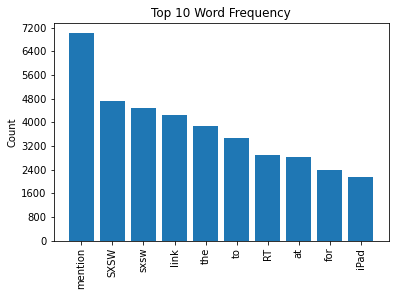

In [27]:
# Create a frequency distribution for X_train
df_freq_dist = FreqDist(df["tweet_tokenized"].explode())

# Plot the top 10 tokens
visualize_top_10(df_freq_dist, "Top 10 Word Frequency")

We saw that there were stop words in our top 10 frequency distribution that needed to be removed.